# DenseNet201 with train data augmentation and TTA

This notebook preprocess the images for training, defines and trains a **DenseNet201** model, and finally creates a submission.

In [1]:
import keras.backend as K
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pickle
import tensorflow as tf

from keras.applications.densenet import DenseNet201, preprocess_input
from keras.callbacks import Callback
from keras.layers import Dense, Dropout, Flatten, GlobalAveragePooling2D
from keras.models import Model, load_model
from keras.optimizers import SGD
from keras.preprocessing import image
from sklearn.metrics import roc_auc_score

Using TensorFlow backend.


In [2]:
# Configure Keras and TensorFlow so that they use the GPU
tf_config = tf.ConfigProto(allow_soft_placement=True)
tf_config.gpu_options.allow_growth = True
sess = tf.Session(config=tf_config) 
K.set_session(sess)

## Read images and labels

In [3]:
data_path = os.path.join(os.getcwd(), '.', 'input')

In [4]:
train_path = os.path.join(data_path, 'train')
labels_path = os.path.join(data_path, 'train_labels.csv')

In [5]:
df = pd.read_csv(labels_path)
# df = df.head(1000)  # Remove this line for full data
df.head()

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0


In [6]:
def crop_roi(img, roi_size=48):
    """Crop a square region in the center of the image."""
    size = img.shape[0]
    roi_ul = (int(size / 2 - roi_size / 2), int(size / 2 - roi_size / 2))
    roi_lr = (int(size / 2 + roi_size / 2), int(size / 2 + roi_size / 2))
    return img[roi_ul[1]: roi_lr[1], roi_ul[0]: roi_lr[0]]

def load_image(img_id, img_size=96, roi_size=None):
    """Load image using its id. Resize and crop is optional."""
    img_path = os.path.join(train_path, '{}.tif'.format(img_id))
    img = image.load_img(img_path, target_size=(img_size, img_size))
    img = image.img_to_array(img)
    if roi_size:
        return crop_roi(img, roi_size)
    return img

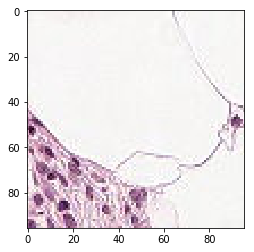

In [7]:
img = load_image(df.id[0])
plt.imshow(img / 255)

## Load and preprocess train set

Let's load all the images and annotations and pickle the results. For future reference the following format is used for pickled names:

`train_images_[img_size]_[roi_size].pkl`

The structure pickled is a numpy array of shape (`N`, `roi_size`, `roi_size`, 3). Where `N` is the size of the train set (220025 in our case), the image channels are in RGB order (Keras' standard) and pixel values aren't normalized (they range from 0 to 255). Images are load from the `.tif` files, resized to `img_size`x`img_size`, and then we crop the center (region of interest) of this image, a square of size `roi_size`x`roi_size`.

In [8]:
img_size = 96
roi_size = None  # Do not crop center square

In [9]:
if roi_size is None:
    size = img_size
else:
    size = roi_size

In [10]:
images = []
labels = []

In [11]:
for idx, row in df.iterrows():
    img_id, label = row
    img = load_image(img_id, img_size=img_size, roi_size=roi_size)
    img = img.reshape(1, size, size, 3)
    images.append(img)
    labels.append(label)

In [12]:
images = np.concatenate(images, axis=0)
labels = np.array(labels).reshape(images.shape[0], 1)

In [13]:
print("images: {}".format(images.shape))
print("labels: {}".format(labels.shape))

images: (220025, 96, 96, 3)
labels: (220025, 1)


## Pickle train data for future usage

Let's save the train set to bu used in other models.

*NOTE*: these images aren't normalized.

In [14]:
# with open(os.path.join(data_path, 'train_images_96_96.pkl'), 'wb') as fout:
#     pickle.dump(images, fout, protocol=4)
# with open(os.path.join(data_path, 'train_labels.pkl'), 'wb') as fout:
#     pickle.dump(labels, fout, protocol=4)

## Modeling

### Normalize images and perform data augmentation

There are several ways of normalizing pixel values, here we use the method used to train **DenseNet201** on *ImageNet* since we are using those pre-trained weights.

In [ ]:
# images = images * 2. / 255. - 1.
# images = preprocess_input(images)

In [15]:
datagen = image.ImageDataGenerator(
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    vertical_flip=True,
    rotation_range=10.,
    fill_mode='reflect',
    width_shift_range=0.1,
    height_shift_range=0.1,
    preprocessing_function=preprocess_input,
)
datagen.fit(images)

### Define callbacks and model architecture

In [16]:
class RocCallback(Callback):
    """Define a callback which returns train ROC AUC after each epoch."""

    def __init__(self, training_data, validation_data=None):
        self.x = training_data[0]
        self.y = training_data[1]
        self.validation = validation_data is not None
        if self.validation:
            self.x_val = validation_data[0]
            self.y_val = validation_data[1]

    def on_train_begin(self, logs={}):
        return

    def on_train_end(self, logs={}):
        return

    def on_epoch_begin(self, epoch, logs={}):
        return

    def on_epoch_end(self, epoch, logs={}):
        y_pred = self.model.predict(self.x)
        roc = roc_auc_score(self.y, y_pred)
        if self.validation:
            y_pred_val = self.model.predict(self.x_val)
            roc_val = roc_auc_score(self.y_val, y_pred_val)
            print('\rroc-auc: {} - roc-auc-val: {}'.format(round(roc, 5), round(roc_val, 5)), end=80 * ' ' + '\n')
        else:
            print('\rroc-auc: {}'.format(round(roc, 5)), end=80 * ' ' + '\n')
        return

    def on_batch_begin(self, batch, logs={}):
        return

    def on_batch_end(self, batch, logs={}):
        return

In [17]:
def densenet201():
    resnet = DenseNet201(include_top=False, weights='imagenet', input_shape=(size, size, 3), pooling='avg')
    x = resnet.output
    # x = Flatten()(x)
    # x = GlobalAveragePooling2D()(x)
    # x = Dropout(0.5)(x)
    # x = Dense(32, activation='relu')(x)
    x = Dense(1, activation='sigmoid')(x)
    return Model(inputs=[resnet.input], outputs=[x])

In [18]:
model = densenet201()
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 96, 96, 3)    0                                            
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, 102, 102, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 48, 48, 64)   9408        zero_padding2d_1[0][0]           
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 48, 48, 64)   256         conv1/conv[0][0]                 
__________________________________________________________________________________________________
conv1/relu

### Train model

In [20]:
model.compile(
    loss='binary_crossentropy',
    optimizer=SGD(lr=1e-4),
    metrics=['accuracy']
)
callbacks = [
    RocCallback(training_data=(images, labels)),
    keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, mode='auto'),
    keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=1e-4, patience=10, mode='auto')
]
model.fit_generator(
    datagen.flow(images, labels, batch_size=128),
    steps_per_epoch=len(images) / 128,
    epochs=epochs,
    validation_split=0.05,
    callbacks=callbacks
)
model.fit(images, labels, batch_size=128, epochs=10, callbacks=callbacks)

Epoch 1/10
220025/220025 [==============================] - 391s 2ms/step - loss: 0.5200 - acc: 0.7445
roc-auc: 0.88545                                                                                
Epoch 2/10
220025/220025 [==============================] - 359s 2ms/step - loss: 0.3874 - acc: 0.8310
roc-auc: 0.91678                                                                                
Epoch 3/10
220025/220025 [==============================] - 359s 2ms/step - loss: 0.3452 - acc: 0.8523
roc-auc: 0.93104                                                                                
Epoch 4/10
220025/220025 [==============================] - 359s 2ms/step - loss: 0.3210 - acc: 0.8641
roc-auc: 0.94011                                                                                
Epoch 5/10
220025/220025 [==============================] - 359s 2ms/step - loss: 0.3024 - acc: 0.8732
roc-auc: 0.94657                                                                                


### Save trained model

In [21]:
model.save('densenet201.h5')

## Test and submission

In [22]:
del images
del labels
images = []
labels = []

In [23]:
test_path = os.path.join(data_path, 'test')
submission_path = os.path.join(data_path, 'sample_submission.csv')

In [24]:
submission = pd.read_csv(submission_path).drop('label', axis=1)
# submission = submission.head(1000)  # Remove this line for full data
submission.head()

,id
0,0b2ea2a822ad23fdb1b5dd26653da899fbd2c0d5
1,95596b92e5066c5c52466c90b69ff089b39f2737
2,248e6738860e2ebcf6258cdc1f32f299e0c76914
3,2c35657e312966e9294eac6841726ff3a748febf
4,145782eb7caa1c516acbe2eda34d9a3f31c41fd6


In [25]:
def load_image(img_id, img_size=96, roi_size=None):
    """Load image using its id. Resize and crop is optional."""
    img_path = os.path.join(test_path, '{}.tif'.format(img_id))
    img = image.load_img(img_path, target_size=(img_size, img_size))
    img = image.img_to_array(img)
    if roi_size:
        return crop_roi(img, roi_size)
    return img

In [26]:
test_images = []
for idx, row in submission.iterrows():
    img_id = row[0]
    img = load_image(img_id, img_size=img_size, roi_size=roi_size)
    img = img.reshape(1, size, size, 3)
    test_images.append(img)
test_images = np.concatenate(test_images, axis=0)

In [27]:
# test_images = test_images * 2. / 255. - 1.
test_images = preprocess_input(test_images)

In [28]:
model = load_model('densenet201.h5')
predictions = model.predict(test_images).squeeze().tolist()

In [29]:
submission['label'] = predictions
submission.to_csv('submission.csv', index=False)